# 日経平均株価 15分足

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import get_name_15min_chart, get_name_15min_chart_usd

In [3]:
code = "N225"
symbol = f"^{code}"
yticker = yf.Ticker(symbol)
df = yticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-02-05 09:00:00+09:00,54289.050781,54294.550781,54027.621094,54116.980469,0,0.0,0.0
2026-02-05 09:15:00+09:00,54115.250000,54338.851562,54115.250000,54332.589844,0,0.0,0.0
2026-02-05 09:30:00+09:00,54323.781250,54459.078125,54302.480469,54413.070312,0,0.0,0.0
2026-02-05 09:45:00+09:00,54408.609375,54420.039062,54323.429688,54365.261719,0,0.0,0.0
2026-02-05 10:00:00+09:00,54369.480469,54406.820312,54336.761719,54347.000000,0,0.0,0.0
2026-02-05 10:15:00+09:00,54341.128906,54354.359375,54169.378906,54265.878906,0,0.0,0.0
2026-02-05 10:30:00+09:00,54266.578125,54307.769531,54222.039062,54295.281250,0,0.0,0.0
2026-02-05 10:45:00+09:00,54291.308594,54291.308594,54163.101562,54169.480469,0,0.0,0.0
2026-02-05 11:00:00+09:00,54172.851562,54186.789062,53858.929688,53858.929688,0,0.0,0.0


In [4]:
dt_start = df.index[0]
dt_end = pd.to_datetime(
    f"{dt_start.year:04d}-{dt_start.month:02d}-{dt_start.day:02d} 15:30:00+09:00"
).tz_convert("Asia/Tokyo")
dt_start, dt_end

(Timestamp('2026-02-05 09:00:00+0900', tz='Asia/Tokyo'),
 Timestamp('2026-02-05 15:30:00+0900', tz='Asia/Tokyo'))

In [5]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = yticker.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 50168.11 # 12/15 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2026-01-29 00:00:00+09:00    53375.601562
2026-01-30 00:00:00+09:00    53322.851562
2026-02-02 00:00:00+09:00    52655.179688
2026-02-03 00:00:00+09:00    54720.660156
2026-02-04 00:00:00+09:00    54293.359375
2026-02-05 00:00:00+09:00    53898.351562
Name: Close, dtype: float64


Date
2026-02-04 00:00:00+09:00    54293.359375
Name: Close, dtype: float64

In [6]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-4.31


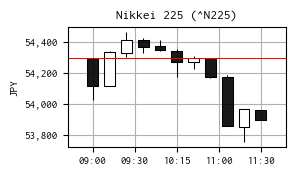

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in yticker.info:
    ax.set_title(f"{yticker.info['shortName']} ({symbol})")
elif "longName" in yticker.info:
    ax.set_title(f"{yticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

In [8]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

In [9]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-02-04 09:00:00+09:00,155.792999,155.923004,155.792999,155.901993,0,0.0,0.0
2026-02-04 09:15:00+09:00,155.893997,155.936996,155.824997,155.871994,0,0.0,0.0
2026-02-04 09:30:00+09:00,155.878998,155.966003,155.865005,155.936005,0,0.0,0.0
2026-02-04 09:45:00+09:00,155.934998,156.035995,155.910995,156.026001,0,0.0,0.0
2026-02-04 10:00:00+09:00,156.018997,156.145996,156.009003,156.097000,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-02-05 10:45:00+09:00,156.931000,156.940994,156.837997,156.852997,0,0.0,0.0
2026-02-05 11:00:00+09:00,156.863007,156.970001,156.848007,156.938004,0,0.0,0.0
2026-02-05 11:15:00+09:00,156.931000,156.960999,156.787994,156.832993,0,0.0,0.0


In [10]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2026-02-05 09:00:00+09:00,345.990682,346.025734,344.324559,344.894057
2026-02-05 09:15:00+09:00,344.825889,346.250692,344.825889,346.210792
2026-02-05 09:30:00+09:00,346.262769,347.125158,346.126996,346.831902
2026-02-05 09:45:00+09:00,347.044604,347.117508,346.501286,346.768111
2026-02-05 10:00:00+09:00,346.600443,346.838482,346.391864,346.457133
2026-02-05 10:15:00+09:00,346.278436,346.362744,345.183992,345.798919
2026-02-05 10:30:00+09:00,345.798970,346.061451,345.515157,345.981873
2026-02-05 10:45:00+09:00,346.128603,346.128603,345.311232,345.351900
2026-02-05 11:00:00+09:00,345.186318,345.275127,343.186026,343.186026


In [11]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2026-02-04 15:15:00+09:00


np.float64(156.26300048828125)

前日終値（ドル換算） 347.44859119143604


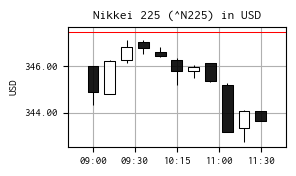

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in yticker.info:
    ax.set_title(f"{yticker.info['shortName']} ({symbol}) in USD")
elif "longName" in yticker.info:
    ax.set_title(f"{yticker.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()